# LLM Zero-shot Reranker Baseline on MovieLens

This notebook runs the **prompted LLM zero-shot reranker** for MovieLens dataset using Llama-3.2-3B-Instruct-bnb-4bit.

**What it does:**
- Loads precomputed splits + candidate pools (history = 3, candidates = 50).
- Loads movie metadata from `movies.dat` and `item_id_map.parquet`.
- Builds 3‑item histories from `train_indexed.parquet`.
- Uses a chat‑style prompt to ask the LLM to **rank the 50 candidate movies**.
- Evaluates **HR@5/10/20** and **NDCG@5/10/20** on VAL and TEST.
- Saves all prompts to JSON files `llama32_3b_val_logs.json`, `llama32_3b_test_logs.json` for inspection.



In [23]:
# Install dependencies
!pip install -q "unsloth[colab-new]" pandas pyarrow numpy scipy tqdm


In [24]:
from google.colab import drive
drive.mount("/content/drive")

from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm
import json

# Paths
# - movies.dat
# - splits/ (train_indexed.parquet, val_targets_indexed.parquet, etc.)
# - candidates/ (val.parquet, test.parquet)
ROOT = Path("/content/drive/MyDrive/deep learning/project 4")

SPLITS = ROOT / "splits"
CANDS = ROOT / "candidates"

# Hyperparameters
#number of recent items per user
HISTORY_LEN = 3
#evaluate HR@K / NDCG@K
TOP_K = 20
#expected candidate pool size
CANDIDATE_SIZE = 50


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Load splits and candidate pools

In [25]:
print("Loading splits and candidate pools...")

train_idx = pd.read_parquet(SPLITS / "train_indexed.parquet")         # [uid, iid, ts]
val_idx   = pd.read_parquet(SPLITS / "val_targets_indexed_100.parquet")   # [uid, iid, ts]
test_idx  = pd.read_parquet(SPLITS / "test_targets_indexed_100.parquet")

cand_val  = pd.read_parquet(CANDS / "val_100.parquet")    # [uid, candidates(list of iids)]
cand_test = pd.read_parquet(CANDS / "test_100.parquet")

print("Example candidate lengths (VAL, first 5 rows):",
 [len(c) for c in cand_val["candidates"].head(5)])

n_users_train_raw = train_idx["uid"].nunique()
n_users_val_raw   = val_idx["uid"].nunique()
n_users_test_raw  = test_idx["uid"].nunique()

print("Raw users in TRAIN:", n_users_train_raw)
print("Raw users in VAL targets:", n_users_val_raw)
print("Raw users in TEST targets:", n_users_test_raw)


Loading splits and candidate pools...
Example candidate lengths (VAL, first 5 rows): [50, 50, 50, 50, 50]
Raw users in TRAIN: 4675
Raw users in VAL targets: 100
Raw users in TEST targets: 100


#Additional validation

In [26]:

# start with checking which users have their true target inside the candidate pool
def mark_coverage(cands_df, targets_df, tgt_col_name: str):
    df = cands_df.merge(
        targets_df[["uid", "iid"]].rename(columns={"iid": tgt_col_name}),
        on="uid",
        how="inner",
    )
    #ensure candidates always a list
    df["candidates"] = df["candidates"].apply(
        lambda x: list(x) if isinstance(x, (list, tuple, np.ndarray, pd.Series)) else []
    )
    #clean up target column
    df[tgt_col_name] = df[tgt_col_name].fillna(-1).astype(int)

    #check if target is in candidate pool
    df["target_in_pool"] = [
        int(t) in set(c) for t, c in zip(df[tgt_col_name], df["candidates"])
    ]
    return df

val_cov  = mark_coverage(cand_val,  val_idx,  "target")
test_cov = mark_coverage(cand_test, test_idx, "target")

covered_val  = val_cov[val_cov["target_in_pool"]].copy()
covered_test = test_cov[test_cov["target_in_pool"]].copy()

val_eval  = covered_val[["uid", "candidates", "target"]].reset_index(drop=True)
test_eval = covered_test[["uid", "candidates", "target"]].reset_index(drop=True)

print(f"Users with target in pool: VAL={len(val_eval)}  TEST={len(test_eval)}")

# after target_in_pool filtering
n_users_val_cov  = val_eval["uid"].nunique()
n_users_test_cov = test_eval["uid"].nunique()

print("Eval users in VAL (with target in pool):", n_users_val_cov)
print("Eval users in TEST (with target in pool):", n_users_test_cov)

val_eval.head()


Users with target in pool: VAL=100  TEST=100
Eval users in VAL (with target in pool): 100
Eval users in TEST (with target in pool): 100


,uid,candidates,target
0,20,"[366, 353, 2029, 1578, 161, 356, 1816, 0, 180,...",0
1,29,"[366, 353, 1578, 161, 356, 1816, 0, 180, 291, ...",1578
2,31,"[366, 353, 2029, 1578, 161, 356, 1816, 0, 180,...",2144
3,53,"[366, 353, 2029, 1578, 161, 356, 0, 180, 291, ...",1780
4,61,"[366, 353, 2029, 1578, 161, 356, 1816, 0, 180,...",1050


#Load movie metadata

In [27]:
print("Loading movie metadata...")

# MovieLens 1M format: MovieID::Title::Genres
movies_raw = pd.read_csv(
    ROOT / "movies.dat",
    sep="::",
    engine="python",
    names=["movieId", "title", "genres"],
    encoding="ISO-8859-1",
)

item_map = pd.read_parquet(SPLITS / "item_id_map.parquet")  # [movieId, iid]

movies = movies_raw.merge(item_map, on="movieId", how="inner")
movies = movies.set_index("iid")

print("Movies with iid mapping:", movies.shape)
movies.head()


Loading movie metadata...
Movies with iid mapping: (2233, 3)


,movieId,title,genres
iid,,,
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,5,Father of the Bride Part II (1995),Comedy
4,6,Heat (1995),Action|Crime|Thriller


#Build user histories

In [28]:
print("Building user histories...")

# Sort by time, then group into full sequences
train_sorted = train_idx.sort_values(["uid", "ts"])
user_history_full = train_sorted.groupby("uid")["iid"].apply(list).to_dict()

# Return last max_len item ids from user's training history
def get_recent_history_iids(uid: int, max_len: int = HISTORY_LEN):
    seq = user_history_full.get(uid, [])
    if not seq:
        return []
    return seq[-max_len:]

# Quick sanity-check for one example user
if len(val_eval) > 0:
    example_uid = int(val_eval.loc[0, "uid"])
    print("Example uid:", example_uid)
    print("Full history iids:", user_history_full.get(example_uid, []))
    print(f"Recent {HISTORY_LEN}:", get_recent_history_iids(example_uid))
else:
    print("val_eval is empty; check splits.")


Building user histories...
Example uid: 20
Full history iids: [496, 318, 492]
Recent 3: [496, 318, 492]


#Define metrics

In [29]:
# returns 1 if target_id is in the first k ranked_ids, else 0
def hit_at_k(ranked_ids, target_id, k=TOP_K):
    return 1.0 if target_id in ranked_ids[:k] else 0.0

# score is higher when the true item is near the top
def ndcg_at_k(ranked_ids, target_id, k=TOP_K):
    for rank, iid in enumerate(ranked_ids[:k], start=1):
        if iid == target_id:
            return 1.0 / np.log2(rank + 1)
    return 0.0

print("Metric helpers defined: HR@K and NDCG@K.")

Metric helpers defined: HR@K and NDCG@K.


#Define and load LLM

In [30]:
from unsloth import FastLanguageModel
import torch

UNSLOTH_MODEL_NAME = "unsloth/Llama-3.2-3B-Instruct-bnb-4bit"

max_seq_length = 4096
dtype = None         # let Unsloth pick (bf16/float16)
load_in_4bit = True  # 4-bit quantization for Colab GPU

print("Loading Unsloth model:", UNSLOTH_MODEL_NAME)

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name=UNSLOTH_MODEL_NAME,
    max_seq_length=max_seq_length,
    dtype=dtype,
    load_in_4bit=load_in_4bit,
)

FastLanguageModel.for_inference(model)
device = model.device

# Make sure padding is defined
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"

print("Model loaded on device:", device)


Loading Unsloth model: unsloth/Llama-3.2-3B-Instruct-bnb-4bit
==((====))==  Unsloth 2025.12.4: Fast Llama patching. Transformers: 4.57.3.
   \\   /|    NVIDIA L4. Num GPUs = 1. Max memory: 22.161 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.1+cu128. CUDA: 8.9. CUDA Toolkit: 12.8. Triton: 3.5.1
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.33.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Model loaded on device: cuda:0


#Build prompt messages

In [31]:
system_prompt = (
    "You are a movie recommendation assistant. "
    "You see a user's watch history and a list of candidate movies, each with an internal ID. "
    "Your job is to choose and rank the candidate movies the user is most likely to enjoy. "
    "Only use the given IDs. "
    "Always follow the requested output format exactly."
)

# Build prompt messages (system + user) for one user by providing user histories and candidates:
# history_entries: list of strings like "Title (Year) | Genres=..."
# candidates: list of dicts: {"iid": int, "title": str, "genres": str}
def build_zero_shot_messages(history_entries, candidates, k=TOP_K):
    if history_entries:
        history_block = "\n".join(f"- {h}" for h in history_entries)
    else:
        history_block = "(no history available)"

    cand_lines = []
    for c in candidates:
        genres = c.get("genres", "Unknown")
        cand_lines.append(
            f"ID={c['iid']} | Title={c['title']} | Genres={genres}"
        )
    candidates_block = "\n".join(cand_lines)

    user_content = f"""
Here is a user and their watch history.

Watch history (movies the user liked):
{history_block}

Here is a list of candidate movies. Each line has an internal ID, the movie title, and its genres.

Candidates:
{candidates_block}

Task:
From the candidate list, select the TOP {k} movies this user is most likely to watch next,
ranking them from most to least likely.

Rules:
- Only choose IDs from the candidate list.
- Do NOT invent new IDs or movies.
- Base your decision on how similar each candidate is to the history, plus your general movie knowledge.

Output format:
Return your answer as a JSON list of IDs only, in order, with no extra text.
For example: [312, 55, 1021, 87, 99]

Now return the JSON list of candidate IDs for this user.
""".strip()

    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_content},
    ]
    return messages

# extract the first JSON list from a string
def extract_json_list(text: str):
    first = text.find("[")
    last = text.rfind("]")
    if first == -1 or last == -1 or last <= first:
        return []
    snippet = text[first:last+1]
    try:
        parsed = json.loads(snippet)
        if isinstance(parsed, list):
            return parsed
    except Exception:
        return []
    return []


#Prompting the LLM

In [32]:
#Run the LLM for a single user and return:
#ranked_ids: list[int] (LLM's ranking over candidate_iids)
#raw_text: the raw text response (for debugging)
#prompt_text: the exact prompt sent (for logging)

def llm_rerank(history_iids, candidate_iids, k=TOP_K, max_new_tokens=256, temperature=0.0):
    # History: titles + genres
    history_entries = []
    for iid in history_iids:
        if iid in movies.index:
            row = movies.loc[iid]
            title = str(row["title"])
            genres = str(row.get("genres", "Unknown"))
            # e.g. "Antz (1998) | Genres=Animation|Children's|Comedy"
            history_entries.append(f"{title} | Genres={genres}")

    # Candidates: IDs + titles + genres
    cand_list = []
    for iid in candidate_iids:
        iid_int = int(iid)
        if iid in movies.index:
            row = movies.loc[iid]
            title = str(row["title"])
            genres = str(row.get("genres", "Unknown"))
            cand_list.append({
                "iid": iid_int,
                "title": title,
                "genres": genres,
            })
        else:
            cand_list.append({
                "iid": iid_int,
                "title": f"Unknown movie (iid={iid_int})",
                "genres": "Unknown",
            })

    # Build messages (this includes genres in both history + candidates)
    messages = build_zero_shot_messages(history_entries, cand_list, k=k)

    # Build model input using chat template (Unsloth Llama)
    input_ids = tokenizer.apply_chat_template(
        messages,
        add_generation_prompt=True,
        return_tensors="pt",
    ).to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            input_ids,
            max_new_tokens=max_new_tokens,
            temperature=temperature,
            do_sample=False,  # greedy for deterministic ranking
        )

    gen_tokens = outputs[0, input_ids.shape[-1]:]
    text = tokenizer.decode(gen_tokens, skip_special_tokens=True).strip()

    # parse JSON list of IDs
    raw_list = extract_json_list(text)   # returns [] on failure
    cand_set = set(int(x) for x in candidate_iids)

    ranked_ids = []
    for x in raw_list:
        try:
            # handle "362" or 362
            iid_int = int(x)
        except Exception:
            continue
        # keep only candidates
        if iid_int in cand_set:
            ranked_ids.append(iid_int)


    # For logging to see the exact prompt:
    prompt_text = tokenizer.decode(input_ids[0], skip_special_tokens=True)

    return ranked_ids, text, prompt_text


#Evaluating LLM performance

In [33]:
#Evaluate the zero-shot LLM reranker on a given split.
#df_eval columns: [uid, candidates(list[iid]), target(int)]
def eval_llm(df_eval, split_name: str, max_users=None, log_path=None):
    hits, ndcgs = [], []
    logs = []

    n_total = len(df_eval)
    n_users = n_total if max_users is None else min(n_total, max_users)

    print(f"\nEvaluating LLM on {split_name} for {n_users} users...")

    processed = 0
    # using tqdm for a progress bar over users
    for idx, row in tqdm(df_eval.iloc[:n_users].iterrows(),total=n_users, desc=f"{split_name} users"):
        uid = int(row["uid"])
        candidate_iids = list(row["candidates"])
        target = int(row["target"])

        # grab user's recent history (last 3 items from train set)
        history_iids = get_recent_history_iids(uid, max_len=HISTORY_LEN)

        # skip if user has no candidates
        if not candidate_iids:
            continue

        # call the LLM to rerank the candidate list given the user history
        ranked_ids, raw_text, prompt_text = llm_rerank(
            history_iids=history_iids,
            candidate_iids=candidate_iids,
            k=TOP_K,
        )

        if not ranked_ids:
            continue

        # keep only IDs that were in the candidate list
        cand_set = set(int(x) for x in candidate_iids)
        ranked_ids = [int(iid) for iid in ranked_ids if iid in cand_set]

        # skip if empty
        if not ranked_ids:
            continue

        # compute metrics given the ranked list and the true target for each user
        h = hit_at_k(ranked_ids, target, k=TOP_K)
        d = ndcg_at_k(ranked_ids, target, k=TOP_K)
        hits.append(h)
        ndcgs.append(d)

        # store everything for our log files
        logs.append({
            "row_index": int(idx),
            "uid": uid,
            "target": target,
            "history_iids": [int(i) for i in history_iids],
            "candidate_iids": [int(i) for i in candidate_iids],
            "ranked_ids": ranked_ids,
            "raw_output": raw_text,
            "prompt_text": prompt_text,
        })

        #stats to keep track of progress
        processed += 1
        if processed % 20 == 0:
            print(
                f"[{split_name}] Processed {processed}/{n_users} users → "
                f"HR@{TOP_K}={np.mean(hits):.3f}, NDCG@{TOP_K}={np.mean(ndcgs):.3f}"
            )

    # average metrics over all users
    hr = float(np.mean(hits)) if hits else 0.0
    ndcg = float(np.mean(ndcgs)) if ndcgs else 0.0
    print(f"[{split_name}] Zero-shot LLM HR@{TOP_K}={hr:.3f}  NDCG@{TOP_K}={ndcg:.3f}")

    # save logs
    if log_path is not None:
        log_path = Path(log_path)
        with open(log_path, "w", encoding="utf-8") as f:
            json.dump(logs, f, indent=2)
        print(f"  Saved {len(logs)} per-user logs to: {log_path}")

    return hr, ndcg, logs


#Run evaluation

In [34]:
# Run evaluation on VAL and TEST splits

# define path to save log files
val_log_path  = ROOT / "llama32_3b_val_logs.json"
test_log_path = ROOT / "llama32_3b_test_logs.json"

# evaluate the LLM reranker on the validation set
val_hr, val_ndcg, val_logs = eval_llm(
    val_eval,
    "VAL",
    max_users=None,
    log_path=val_log_path,
)

# evaluate the LLM reranker on the test set
test_hr, test_ndcg, test_logs = eval_llm(
    test_eval,
    "TEST",
    max_users=None,
    log_path=test_log_path,
)

# print the final metrics summary
print("\n=== SUMMARY ===")
print(f"VAL  HR@{TOP_K}={val_hr:.3f}  NDCG@{TOP_K}={val_ndcg:.3f}")
print(f"TEST HR@{TOP_K}={test_hr:.3f}  NDCG@{TOP_K}={test_ndcg:.3f}")

# print one example from our log files
if val_logs:
    print("\nExample VAL log entry:")
    from pprint import pprint
    pprint(val_logs[0])



Evaluating LLM on VAL for 100 users...


VAL users:  20%|██        | 20/100 [01:17<04:59,  3.74s/it]

[VAL] Processed 20/100 users → HR@20=0.550, NDCG@20=0.287


VAL users:  41%|████      | 41/100 [02:59<03:57,  4.02s/it]

[VAL] Processed 40/100 users → HR@20=0.550, NDCG@20=0.240


VAL users:  61%|██████    | 61/100 [04:36<03:47,  5.83s/it]

[VAL] Processed 60/100 users → HR@20=0.550, NDCG@20=0.237


VAL users:  82%|████████▏ | 82/100 [06:13<01:23,  4.62s/it]

[VAL] Processed 80/100 users → HR@20=0.487, NDCG@20=0.209


VAL users: 100%|██████████| 100/100 [07:29<00:00,  4.49s/it]


[VAL] Zero-shot LLM HR@20=0.500  NDCG@20=0.216
  Saved 98 per-user logs to: /content/drive/MyDrive/deep learning/project 4/llama32_3b_val_logs.json

Evaluating LLM on TEST for 100 users...


TEST users:  20%|██        | 20/100 [01:16<05:00,  3.76s/it]

[TEST] Processed 20/100 users → HR@20=0.450, NDCG@20=0.133


TEST users:  40%|████      | 40/100 [02:35<03:48,  3.80s/it]

[TEST] Processed 40/100 users → HR@20=0.550, NDCG@20=0.186


TEST users:  60%|██████    | 60/100 [04:05<02:40,  4.00s/it]

[TEST] Processed 60/100 users → HR@20=0.617, NDCG@20=0.218


TEST users:  80%|████████  | 80/100 [05:29<01:27,  4.38s/it]

[TEST] Processed 80/100 users → HR@20=0.575, NDCG@20=0.218


TEST users: 100%|██████████| 100/100 [06:54<00:00,  4.15s/it]

[TEST] Processed 100/100 users → HR@20=0.550, NDCG@20=0.206
[TEST] Zero-shot LLM HR@20=0.550  NDCG@20=0.206
  Saved 100 per-user logs to: /content/drive/MyDrive/deep learning/project 4/llama32_3b_test_logs.json

=== SUMMARY ===
VAL  HR@20=0.500  NDCG@20=0.216
TEST HR@20=0.550  NDCG@20=0.206

Example VAL log entry:
{'candidate_iids': [366,
                    353,
                    2029,
                    1578,
                    161,
                    356,
                    1816,
                    0,
                    180,
                    291,
                    730,
                    665,
                    504,
                    1364,
                    1579,
                    2199,
                    2144,
                    735,
                    499,
                    76,
                    3892,
                    1698,
                    3985,
                    3896,
                    2539,
                    3659,
                    2546

## Fine-tuning Llama-3.2-3B-Instruct on MovieLens (CTR)

Now we extended the zero-shot reranker into a finetuned LLM that learns a binary "like / not-like" classifier (Click Through Rate - CTR). We then use the finetuned model as a scorer over the same candidate pools used earlier.

1. Build a CTR-style dataset from the MovieLens training split:
   - each example = (user history, candidate movie, label ∈ {YES(1), NO(0)}).
2. Convert these examples into instruction-style text prompts.
3. Finetune the Llama-3.2-3B-Instruct model with LoRA (via Unsloth).
4. Use the finetuned model to score candidates with p(YES | history, candidate) and rank candidates by this score.
5. Evaluate HR@K / NDCG@K on the same val/test splits as the zero-shot reranker.

In [35]:
import random
from datasets import Dataset

print("Building CTR-style fine-tuning dataset from train split...")

# Hyperparameters for CTR dataset
# max items from user history per example
MAX_HISTORY_LEN_CTR = 3
# negative samples per positive
NUM_NEGATIVES_PER_POS = 1
# max number of (history, item, label) examples
MAX_TRAIN_EXAMPLES = 20000
# fraction of CTR data for validation
VAL_FRACTION = 0.1

# set seed value
rng = np.random.default_rng(42)

# Build full interaction sequences per user
train_sorted_ctr = train_idx.sort_values(["uid", "ts"])
user_seqs = train_sorted_ctr.groupby("uid")["iid"].apply(list).to_dict()

all_items = movies.index.to_numpy()
n_all_items = len(all_items)

ctr_examples = []

#build positive and negative examples for each user

for uid, seq in user_seqs.items():
    # require at least 2 interactions to form (history, next_item) pairs
    if len(seq) < 2:
        continue

    user_pos_set = set(seq)
    for t in range(1, len(seq)):
        history = seq[:t]
        target = seq[t]

        # truncate history to most recent MAX_HISTORY_LEN_CTR
        hist_trunc = history[-MAX_HISTORY_LEN_CTR:]

        # positive examples
        ctr_examples.append(
            {
                "uid": int(uid),
                "history": [int(x) for x in hist_trunc],
                "item": int(target),
                "label": 1,
            }
        )

        # negative examples
        for _ in range(NUM_NEGATIVES_PER_POS):
            # sample until we find an item user has never interacted with
            while True:
                neg_item = int(all_items[rng.integers(0, n_all_items)])
                if neg_item not in user_pos_set:
                    break
            ctr_examples.append(
                {
                    "uid": int(uid),
                    "history": [int(x) for x in hist_trunc],
                    "item": int(neg_item),
                    "label": 0,
                }
            )

print(f"Total raw CTR examples: {len(ctr_examples):,}")

# shuffle for training and cut it down to max train examples
rng.shuffle(ctr_examples)
if len(ctr_examples) > MAX_TRAIN_EXAMPLES:
    ctr_examples = ctr_examples[:MAX_TRAIN_EXAMPLES]

print(f"Using {len(ctr_examples):,} CTR examples for fine-tuning.")


# convert (history, item, label) into text for SFT training
def build_ctr_text_example(ex):
    uid = ex["uid"]
    hist_iids = ex["history"]
    item_iid = ex["item"]
    label = ex["label"]

    # build history block
    history_entries = []
    for iid in hist_iids:
        if iid in movies.index:
            row = movies.loc[iid]
            title = str(row["title"])
            genres = str(row.get("genres", "Unknown"))
            history_entries.append(f"- {title} | Genres={genres}")
    if history_entries:
        history_block = "\n".join(history_entries)
    else:
        history_block = "(no history available)"

    # grab candidate movie title and genre
    if item_iid in movies.index:
        row_c = movies.loc[item_iid]
        cand_title = str(row_c["title"])
        cand_genres = str(row_c.get("genres", "Unknown"))
    else:
        cand_title = f"Item {item_iid}"
        cand_genres = "Unknown"

    candidate_block = f"Title: {cand_title}\nGenres: {cand_genres}"

    answer_str = "YES" if label == 1 else "NO"

    # instruction-style prompt + answer
    text = (
        "You are a movie recommendation assistant.\n"
        "Given a user's watch history and ONE candidate movie, decide if the user is likely to enjoy the candidate.\n"
        "Answer with exactly one word: YES or NO.\n\n"
        "[USER HISTORY]\n"
        f"{history_block}\n\n"
        "[CANDIDATE]\n"
        f"{candidate_block}\n\n"
        "[QUESTION]\n"
        "Will the user like this movie?\n\n"
        "[ANSWER]\n"
        f"{answer_str}"
    )

    return text

# convert all examples to text
ctr_texts = [build_ctr_text_example(ex) for ex in ctr_examples]

# append EOS token so training knows where to stop generations
EOS_TOKEN = tokenizer.eos_token or "</s>"
ctr_texts = [t + EOS_TOKEN for t in ctr_texts]

# wrap into a DataFrame then HuggingFace Dataset
ctr_df = pd.DataFrame(
    {
        "uid": [ex["uid"] for ex in ctr_examples],
        "history": [ex["history"] for ex in ctr_examples],
        "item": [ex["item"] for ex in ctr_examples],
        "label": [ex["label"] for ex in ctr_examples],
        "text": ctr_texts,
    }
)

# train/val split
val_size = max(1, int(len(ctr_df) * VAL_FRACTION))
train_df_ctr = ctr_df.iloc[:-val_size].reset_index(drop=True)
val_df_ctr = ctr_df.iloc[-val_size:].reset_index(drop=True)

train_dataset_ctr = Dataset.from_pandas(train_df_ctr[["text"]])
val_dataset_ctr = Dataset.from_pandas(val_df_ctr[["text"]])

print("Train CTR dataset size:", len(train_dataset_ctr))
print("Val CTR dataset size:", len(val_dataset_ctr))

ctr_df.head()

Building CTR-style fine-tuning dataset from train split...
Total raw CTR examples: 15,764
Using 15,764 CTR examples for fine-tuning.
Train CTR dataset size: 14188
Val CTR dataset size: 1576


,uid,history,item,label,text
0,2617,"[955, 1236]",1387,1,You are a movie recommendation assistant.\nGiv...
1,636,[356],2139,0,You are a movie recommendation assistant.\nGiv...
2,2050,[1753],1983,1,You are a movie recommendation assistant.\nGiv...
3,1582,[2211],1768,0,You are a movie recommendation assistant.\nGiv...
4,4582,[9],2119,0,You are a movie recommendation assistant.\nGiv...


In [36]:
# @title Save finetuning datasets to JSONL files

save_dir = ROOT / "ctr_datasets"
save_dir.mkdir(parents=True, exist_ok=True)

all_path = save_dir / "movielens_ctr_all.jsonl"
train_path = save_dir / "movielens_ctr_train.jsonl"
val_path = save_dir / "movielens_ctr_val.jsonl"

# save full CTR dataframe (uid, history, item, label, text)
ctr_df.to_json(all_path, orient="records", lines=True, force_ascii=False)

# save train split
train_df_ctr.to_json(train_path, orient="records", lines=True, force_ascii=False)

# save val split
val_df_ctr.to_json(val_path, orient="records", lines=True, force_ascii=False)

print("Saved finetuning CTR datasets to:")
print("All: ", all_path)
print("Train: ", train_path)
print("Val: ", val_path)

# print one example entry
print("\nExample from ctr_df:")
example_dict = ctr_df.iloc[0].to_dict()
print(example_dict)

Saved finetuning CTR datasets to:
All:  /content/drive/MyDrive/deep learning/project 4/ctr_datasets/movielens_ctr_all.jsonl
Train:  /content/drive/MyDrive/deep learning/project 4/ctr_datasets/movielens_ctr_train.jsonl
Val:  /content/drive/MyDrive/deep learning/project 4/ctr_datasets/movielens_ctr_val.jsonl

Example from ctr_df:
{'uid': 2617, 'history': [955, 1236], 'item': 1387, 'label': 1, 'text': "You are a movie recommendation assistant.\nGiven a user's watch history and ONE candidate movie, decide if the user is likely to enjoy the candidate.\nAnswer with exactly one word: YES or NO.\n\n[USER HISTORY]\n- Witness (1985) | Genres=Drama|Romance|Thriller\n- Your Friends and Neighbors (1998) | Genres=Drama\n\n[CANDIDATE]\nTitle: You've Got Mail (1998)\nGenres: Comedy|Romance\n\n[QUESTION]\nWill the user like this movie?\n\n[ANSWER]\nYES<|eot_id|>"}


In [37]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

print("\nInitializing Llama-3.2-3B-Instruct model again for LoRA fine-tuning...")

# load the same base model again for training with LoRA adapters.
max_seq_length = 2048
dtype = None
load_in_4bit = True

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = UNSLOTH_MODEL_NAME,
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

# attach LoRA adapters
model = FastLanguageModel.get_peft_model(
    model,
    r = 16,
    target_modules = [
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj",
    ],
    lora_alpha = 16,
    lora_dropout = 0.0,
    bias = "none",
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
    use_rslora = False,
    loftq_config = None,
)

print("LoRA-based model ready for training.")
print(model)

# SFTTrainer for supervised fine-tuning on the 'text' field
ctr_trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_dataset_ctr,
    eval_dataset = val_dataset_ctr,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    packing = False,
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 200,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 10,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = str(ROOT / "llm_ctr_lora_outputs"),
        report_to = "none",
    ),
)




Initializing Llama-3.2-3B-Instruct model again for LoRA fine-tuning...
==((====))==  Unsloth 2025.12.4: Fast Llama patching. Transformers: 4.57.3.
   \\   /|    NVIDIA L4. Num GPUs = 1. Max memory: 22.161 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.1+cu128. CUDA: 8.9. CUDA Toolkit: 12.8. Triton: 3.5.1
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.33.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
LoRA-based model ready for training.
PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 3072, padding_idx=128004)
        (layers): ModuleList(
          (0-27): 28 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=3072, out_features=3072, bias=False)
               

Unsloth: Tokenizing ["text"] (num_proc=16):   0%|          | 0/14188 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"] (num_proc=16):   0%|          | 0/1576 [00:00<?, ? examples/s]

In [38]:
# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA L4. Max memory = 22.161 GB.
7.904 GB of memory reserved.


In [45]:
import time
start = time.perf_counter()

# @title Start finetuning
print("Starting fine-tuning...")
ctr_train_stats = ctr_trainer.train()

end = time.perf_counter()
total_time = end - start

print(f"Total training time: {total_time:.2f} seconds")

The model is already on multiple devices. Skipping the move to device specified in `args`.


Starting fine-tuning...


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 14,188 | Num Epochs = 1 | Total steps = 200
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 24,313,856 of 3,237,063,680 (0.75% trained)


Step,Training Loss
10,0.256000
20,0.250000
30,0.247800
40,0.242600
50,0.245300
60,0.231900
70,0.242400
80,0.237800
90,0.243300
100,0.227400


Total training time: 308.91 seconds


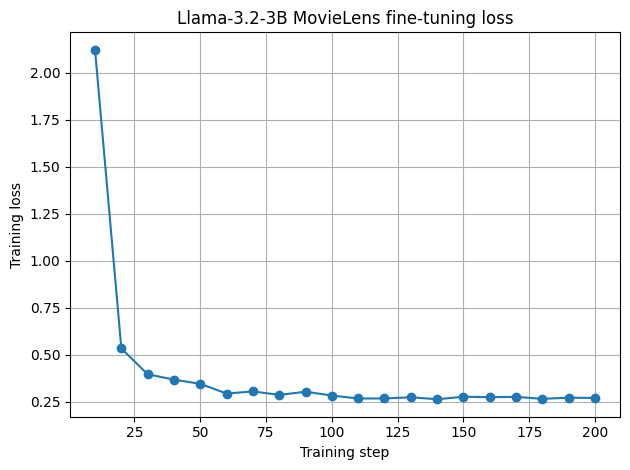

In [40]:
import matplotlib.pyplot as plt

steps = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100,
         110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
losses = [2.1226, 0.5345, 0.3972, 0.3686, 0.3464, 0.2946, 0.3060, 0.2874,
          0.3043, 0.2841, 0.2683, 0.2686, 0.2748, 0.2643, 0.2776, 0.2755,
          0.2769, 0.2665, 0.2726, 0.2710]

plt.figure()
plt.plot(steps, losses, marker="o")
plt.xlabel("Training step")
plt.ylabel("Training loss")
plt.title("Llama-3.2-3B MovieLens fine-tuning loss")
plt.grid(True)
plt.tight_layout()
plt.savefig("llama32_movielens_loss_curve.pdf")


In [41]:
# @title Save the fine-tuned LoRA model + tokenizer

lora_save_dir = ROOT / "llama3.2_3b_movielens_ctr_lora"
lora_save_dir.mkdir(parents=True, exist_ok=True)

print("Saving LoRA model to:", lora_save_dir)

model.save_pretrained(str(lora_save_dir))
tokenizer.save_pretrained(str(lora_save_dir))

print("Saved!")

Saving LoRA model to: /content/drive/MyDrive/deep learning/project 4/llama3.2_3b_movielens_ctr_lora
Saved!


In [42]:
import torch
# @title Define candidate score helper
print("\nDefining helper to score candidates with p(YES | history, candidate)...")

# precompute token IDs for "YES" and "NO"
yes_token_ids = tokenizer.encode("YES", add_special_tokens=False)
no_token_ids = tokenizer.encode("NO", add_special_tokens=False)

if len(yes_token_ids) == 0 or len(no_token_ids) == 0:
    raise ValueError("Tokenizer did not produce tokens for 'YES' or 'NO'")

def score_candidate_yes_prob(history_iids, candidate_iid) -> float:
    # build history block
    history_entries = []
    for iid in history_iids:
        if iid in movies.index:
            row = movies.loc[iid]
            title = str(row["title"])
            genres = str(row.get("genres", "Unknown"))
            history_entries.append(f"- {title} | Genres={genres}")
    if history_entries:
        history_block = "\n".join(history_entries)
    else:
        history_block = "(no history available)"

    # candidate title and genres
    if candidate_iid in movies.index:
        row_c = movies.loc[candidate_iid]
        cand_title = str(row_c["title"])
        cand_genres = str(row_c.get("genres", "Unknown"))
    else:
        cand_title = f"Item {candidate_iid}"
        cand_genres = "Unknown"

    candidate_block = f"Title: {cand_title}\nGenres: {cand_genres}"

    # build inference prompt with same structure as training but without the answer
    prompt = (
        "You are a movie recommendation assistant.\n"
        "Given a user's watch history and ONE candidate movie, decide if the user is likely to enjoy the candidate.\n"
        "Answer with exactly one word: YES or NO.\n\n"
        "[USER HISTORY]\n"
        f"{history_block}\n\n"
        "[CANDIDATE]\n"
        f"{candidate_block}\n\n"
        "[QUESTION]\n"
        "Will the user like this movie?\n\n"
        "[ANSWER]\n"
    )

    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        truncation=True,
        max_length=max_seq_length,
    ).to(model.device)

    with torch.no_grad():
        outputs = model(**inputs)
        # logits for next token after the prompt
        logits = outputs.logits[0, -1, :]

    # approximate p(YES) using the first token of "YES" vs "NO"
    yes_logit = logits[yes_token_ids[0]]
    no_logit = logits[no_token_ids[0]]

    # convert to probability (sigmoid of logit difference)
    score = torch.sigmoid(yes_logit - no_logit).item()
    return float(score)


Defining helper to score candidates with p(YES | history, candidate)...


In [43]:
# @title Define eval llm helper function
import json

print("\nDefining helper to evaluate the finetuned llm as reranker...")

def eval_llm_ctr_reranker(df_eval, split_name: str, max_users=None, log_path=None):
    hits, ndcgs = [], []
    logs = []

    n_total = len(df_eval)
    n_users = n_total if max_users is None else min(n_total, max_users)
    print(f"\nEvaluating fine-tuned CTR-LLM on {split_name} for {n_users} users...")

    # using tqdm for a progress bar over users
    for idx, row in tqdm(df_eval.iloc[:n_users].iterrows(),total=n_users,desc=f"{split_name} users"):
        uid = row["uid"]
        candidate_iids = row["candidates"]
        target_iid = row["target"]

        # grab history ids
        history_iids = get_recent_history_iids(uid, max_len=MAX_HISTORY_LEN_CTR)

        # score each candidate
        scores = [score_candidate_yes_prob(history_iids, iid) for iid in candidate_iids]

        # sort by score desc
        ranked = sorted(
            zip(candidate_iids, scores),
            key=lambda x: x[1],
            reverse=True,
        )
        ranked_ids = [iid for iid, _ in ranked]
        ranked_scores = [s for _, s in ranked]

        # compute metrics
        hit  = hit_at_k(ranked_ids, target_iid, k=TOP_K)
        ndcg = ndcg_at_k(ranked_ids, target_iid, k=TOP_K)
        hits.append(hit)
        ndcgs.append(ndcg)

        # add log entries
        logs.append(
          {
            "split": split_name,
            "uid": int(uid),
            "target": int(target_iid),
            "candidates": [int(x) for x in candidate_iids],
            "scores": ranked_scores,
            "ranking": [int(x) for x in ranked_ids],
            "hit_at_k": float(hit),
            "ndcg_at_k": float(ndcg),
          }
        )

    hr = float(np.mean(hits)) if hits  else 0.0
    ndcg = float(np.mean(ndcgs)) if ndcgs else 0.0
    print(f"[{split_name}] Fine-tuned CTR-LLM HR@{TOP_K}={hr:.3f}  NDCG@{TOP_K}={ndcg:.3f}")

    # save logs
    if log_path is not None:
        log_path = Path(log_path)
        log_path.parent.mkdir(parents=True, exist_ok=True)
        with open(log_path, "w", encoding="utf-8") as f:
            json.dump(logs, f, indent=2)
        print(f"Saved {len(logs)} log entries to: {log_path}")

    return hr, ndcg, logs


Defining helper to evaluate the finetuned llm as reranker...


In [44]:
from pprint import pprint

# define paths for fine-tuned logs
ctr_val_log_path = ROOT / "llama32_3b_ctr_val_logs.json"
ctr_test_log_path = ROOT / "llama32_3b_ctr_test_logs.json"

# evaluate the fine-tuned CTR LLM reranker on validation set
ft_val_hr, ft_val_ndcg, ft_val_logs = eval_llm_ctr_reranker(
    val_eval,
    "VAL-CTR-FT",
    max_users=None,
    log_path=ctr_val_log_path,
)

# evaluate the fine-tuned CTR LLM reranker on test split
ft_test_hr, ft_test_ndcg, ft_test_logs = eval_llm_ctr_reranker(
    test_eval,
    "TEST-CTR-FT",
    max_users=None,
    log_path=ctr_test_log_path,
)

# print final metrics summary
print("\n=== Fine-tuned LLM SUMMARY ===")
print(f"VAL  HR@{TOP_K}={ft_val_hr:.3f}  NDCG@{TOP_K}={ft_val_ndcg:.3f}")
print(f"TEST HR@{TOP_K}={ft_test_hr:.3f}  NDCG@{TOP_K}={ft_test_ndcg:.3f}")

# print one example from our log files
if ft_val_logs:
    print("\nExample VAL-CTR-FT log entry:")
    pprint(ft_val_logs[0])



Evaluating fine-tuned CTR-LLM on VAL-CTR-FT for 100 users...


VAL-CTR-FT users: 100%|██████████| 100/100 [08:38<00:00,  5.19s/it]


[VAL-CTR-FT] Fine-tuned CTR-LLM HR@20=0.810  NDCG@20=0.288
Saved 100 log entries to: /content/drive/MyDrive/deep learning/project 4/llama32_3b_ctr_val_logs.json

Evaluating fine-tuned CTR-LLM on TEST-CTR-FT for 100 users...


TEST-CTR-FT users: 100%|██████████| 100/100 [08:37<00:00,  5.17s/it]

[TEST-CTR-FT] Fine-tuned CTR-LLM HR@20=0.720  NDCG@20=0.251
Saved 100 log entries to: /content/drive/MyDrive/deep learning/project 4/llama32_3b_ctr_test_logs.json

=== Fine-tuned LLM SUMMARY ===
VAL  HR@20=0.810  NDCG@20=0.288
TEST HR@20=0.720  NDCG@20=0.251

Example VAL-CTR-FT log entry:
{'candidates': [366,
                353,
                2029,
                1578,
                161,
                356,
                1816,
                0,
                180,
                291,
                730,
                665,
                504,
                1364,
                1579,
                2199,
                2144,
                735,
                499,
                76,
                3892,
                1698,
                3985,
                3896,
                2539,
                3659,
                2546,
                3871,
                3748,
                1826,
                2035,
                1195,
                642,
 